# Stellar Spectra

Stellar spectra can be generated by combining a `Stars` object with an ``EmissionModel``, translating the properties of the stellar populations (typically `initial_masses`, `ages` and `metallicities`) to a spectral energy distribution. 

These models are described in detail in the [emission model docs](../emission_models/emission_models.rst). 
Here, we'll use an instance of a ``PacmanEmission`` model for demonstration purposes.

The following sections demonstrate the generation of *integrated* spectra (which is the same for both parametric and particle ``Stars``), and *per--particle* spectra. 


In [1]:
from unyt import K, Myr

from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Greybody
from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.parametric import SFH, Stars, ZDist

tau_v = 0.5
# dust curve slope
alpha = -1.0
dust_curve = PowerLaw(slope=alpha)
dust_emission_model = Greybody(30 * K, 1.2)

grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)

stellar_mass = 10**11  # Msol
sfh = SFH.Constant(max_age=100 * Myr)
metal_dist = ZDist.Normal(mean=0.01, sigma=0.05)

# Get the 2D star formation and metal enrichment history for the
# given SPS grid. This is (age, Z).
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=stellar_mass,
)

# Get the model
pacman = PacmanEmission(
    grid=grid,
    tau_v=tau_v,
    dust_curve=dust_curve,
    dust_emission=dust_emission_model,
)

## Integrated spectra

To generate integrated spectra we simply call the components ``get_spectra`` method. This method will populate the component's ``spectra`` attribute with a dictionary containing [Sed objects](../sed/sed.rst) for each spectra in the ``EmissionModel`` and will also return the spectra at the root of the ``EmissionModel``.

In [2]:
# Get the spectra using a unified agn model (instantiated elsewhere)
spectra = stars.get_spectra(pacman)

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: overflow encountered in multiply
  out_arr = func(


We can plot the resulting spectra using the ``plot_spectra`` method.

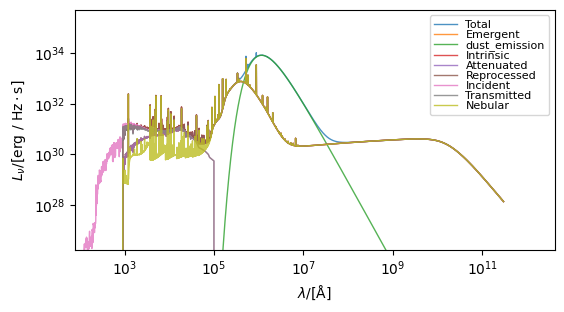

In [3]:
fig, ax = stars.plot_spectra(show=True, figsize=(6, 4))

The spectra returned by ``get_spectra`` is the "total" spectra at the root of the emission model.

In [4]:
print(spectra)

+-------------------------------------------------------------------------------+
|                                      SED                                      |
+-------------+-----------------------------------------------------------------+
| Attribute   | Value                                                           |
+-------------+-----------------------------------------------------------------+
| redshift    | 0                                                               |
+-------------+-----------------------------------------------------------------+
| lam (9244,) | 1.30e-04 Å -> 2.99e+11 Å (Mean: 9.73e+09 Å)                     |
+-------------+-----------------------------------------------------------------+
| nu (9244,)  | 1.00e+07 Hz -> 2.31e+22 Hz (Mean: 8.51e+19 Hz)                  |
+-------------+-----------------------------------------------------------------+
| lnu (9244,) | 0.00e+00 erg/(Hz*s) -> 1.07e+34 erg/(Hz*s) (Mean: 3.96e+32 erg) |
+-------------+-

However, all the spectra are stored within a dictionary under the ``spectra`` attribute on the relevant component.

In [5]:
print(stars.spectra)

{'nebular': <synthesizer.sed.Sed object at 0x7ffa9477f010>, 'transmitted': <synthesizer.sed.Sed object at 0x7ffa9477f790>, 'incident': <synthesizer.sed.Sed object at 0x7ffa947c1bd0>, 'reprocessed': <synthesizer.sed.Sed object at 0x7ffa947c2620>, 'attenuated': <synthesizer.sed.Sed object at 0x7ffa947c3f40>, 'intrinsic': <synthesizer.sed.Sed object at 0x7ffa947c3ee0>, 'dust_emission': <synthesizer.sed.Sed object at 0x7ffa947c18d0>, 'emergent': <synthesizer.sed.Sed object at 0x7ffa947c1300>, 'total': <synthesizer.sed.Sed object at 0x7ffa947c3340>}


## Particle spectra

In this example we load some test particle data from CAMELS:

In [6]:
# Create stars component object
stars = load_CAMELS_IllustrisTNG(
    "../../../tests/data/",
    snap_name="camels_snap.hdf5",
    group_name="camels_subhalo.hdf5",
    physical=True,
)[1].stars

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


To generate a spectra for each star particle we use the same model, but we need to tell the model to produce a spectrum for each particle. This is done by setting the ``per_particle`` flag to ``True`` on the model.

In [7]:
pacman.set_per_particle(True)

With that done we just call the same ``get_spectra`` method on the component, and the particle spectra will be stored in the ``particle_spectra`` attribute of the component.

In [8]:
spectra = stars.get_spectra(pacman, verbose=True)

Again, the returned spectra is the "total" spectra from the root of the model.

In [9]:
print(spectra)

+-----------------------------------------------------------------------------------+
|                                        SED                                        |
+-----------------+-----------------------------------------------------------------+
| Attribute       | Value                                                           |
+-----------------+-----------------------------------------------------------------+
| redshift        | 0                                                               |
+-----------------+-----------------------------------------------------------------+
| lam (9244,)     | 1.30e-04 Å -> 2.99e+11 Å (Mean: 9.73e+09 Å)                     |
+-----------------+-----------------------------------------------------------------+
| nu (9244,)      | 1.00e+07 Hz -> 2.31e+22 Hz (Mean: 8.51e+19 Hz)                  |
+-----------------+-----------------------------------------------------------------+
| lnu (120, 9244) | 0.00e+00 erg/(Hz*s) -> 5.55e+29 er

While the spectra produced by ``get_particle_spectra`` are stored in a dictionary under the ``particle_spectra`` attribute.

In [10]:
print(stars.particle_spectra)

{'nebular': <synthesizer.sed.Sed object at 0x7ffa4a346350>, 'transmitted': <synthesizer.sed.Sed object at 0x7ffa4a604a90>, 'incident': <synthesizer.sed.Sed object at 0x7ffa4439ea40>, 'reprocessed': <synthesizer.sed.Sed object at 0x7ffa443e54b0>, 'attenuated': <synthesizer.sed.Sed object at 0x7ffa443e60b0>, 'intrinsic': <synthesizer.sed.Sed object at 0x7ffa443e6bf0>, 'dust_emission': <synthesizer.sed.Sed object at 0x7ffa443e4d30>, 'emergent': <synthesizer.sed.Sed object at 0x7ffa443e4850>, 'total': <synthesizer.sed.Sed object at 0x7ffa947c27a0>}


### Integrating spectra

The integrated spectra are automatically produced alongside per particle spectra. However, if we wanted to explictly get the integrated spectra from the particle spectra we just generated (for instance if we had made some modification after generation), we can call the ``integrate_particle_spectra`` method.
This method will sum the individual spectra, and populate the ``spectra`` dictionary.

Note that we can also integrate individual spectra using the [``Sed.sum()`` method](../sed/sed.ipynb).

{'nebular': <synthesizer.sed.Sed object at 0x7ffa4439f520>, 'transmitted': <synthesizer.sed.Sed object at 0x7ffa4435b460>, 'incident': <synthesizer.sed.Sed object at 0x7ffa4439eb60>, 'reprocessed': <synthesizer.sed.Sed object at 0x7ffa443e5060>, 'attenuated': <synthesizer.sed.Sed object at 0x7ffa443e5660>, 'intrinsic': <synthesizer.sed.Sed object at 0x7ffa443e6140>, 'dust_emission': <synthesizer.sed.Sed object at 0x7ffa443e57e0>, 'emergent': <synthesizer.sed.Sed object at 0x7ffa947c28f0>, 'total': <synthesizer.sed.Sed object at 0x7ffa947c2ce0>}
{'nebular': <synthesizer.sed.Sed object at 0x7ffa947c0eb0>, 'transmitted': <synthesizer.sed.Sed object at 0x7ffa4439f520>, 'incident': <synthesizer.sed.Sed object at 0x7ffa4435b460>, 'reprocessed': <synthesizer.sed.Sed object at 0x7ffa4439eb60>, 'attenuated': <synthesizer.sed.Sed object at 0x7ffa947c25f0>, 'intrinsic': <synthesizer.sed.Sed object at 0x7ffa443e65f0>, 'dust_emission': <synthesizer.sed.Sed object at 0x7ffa443e5660>, 'emergent': <sy

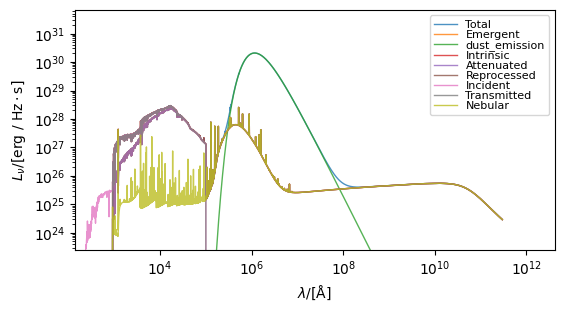

In [11]:
print(stars.spectra)
stars.integrate_particle_spectra()
print(stars.spectra)

fig, ax = stars.plot_spectra(show=True, figsize=(6, 4))

## Modifying `EmissionModel` parameters with `get_spectra`

As well as modifying a model explicitly, it's also possible to overide the properties of a model at the point `get_spectra` is called. These modifications will not be remembered by the model afterwards. As it stands, this form of modifications is supported for the `dust_curve`, `tau_v`, `fesc` and `masks`.

Here we'll demonstrate this by overiding the optical depths to generate spectra for a range of `tau_v` values. This can either be done by passing a single number which will overide all optical depths on every model.

In [12]:
# Since we now want integrated spectra lets remove the per particle flag
pacman.set_per_particle(False)

stars.clear_all_spectra()
spectra = {}
for tau_v in [0.1, 0.5, 1.0]:
    stars.get_spectra(pacman, tau_v=tau_v)
    spectra[r"$\tau_v " f"= {tau_v}"] = stars.spectra["attenuated"]

Or we can pass a dictionary mapping model labels to `tau_v` values to target specific models. Notice that we have invoked the `clear_all_spectra` method to reset the spectra dictionary, we can also clear all emissions (including spectra, lines, and photometry if they are present) with the `clear_all_emissions` method.

In [13]:
stars.clear_all_emissions()
spectra = {}
for tau_v in [0.1, 0.5, 1.0]:
    stars.get_spectra(pacman, tau_v={"attenuated": tau_v})
    spectra[r"$\tau_v " f"=$ {tau_v}"] = stars.spectra["attenuated"]

To see the variation above we can pass the dictionary we populated with the varied spectra to the `plot_spectra` function (where the dictionary keys will be used as labels). 

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{\\AA}]$', ylabel='$L_{\\nu}/[\\mathrm{\\rm{erg} \\ / \\ \\rm{Hz \\cdot \\rm{s}}}]$'>)

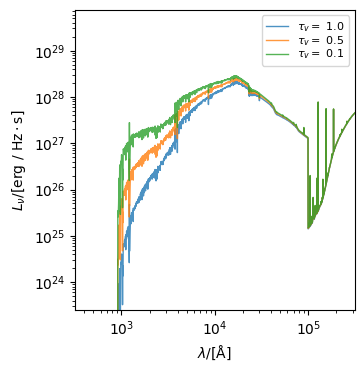

In [14]:
from synthesizer.sed import plot_spectra

plot_spectra(spectra, xlimits=(10**2.5, 10**5.5))